In [1]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [2]:
%load_ext blackcellmagic

In [3]:
%load_ext autoreload
%autoreload 2

In [12]:
# vis based on different metrics 
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import warnings

from REVIVAL.analysis import ndcg, ndcg_scale, custom_ndcg, calc_top_n_percent_recall
from REVIVAL.util import get_file_name

# Suppress only ConstantInputWarning
warnings.simplefilter("ignore", category=UserWarning)


In [5]:
parlq_df = pd.read_csv("/disk2/fli/REVIVAL2/zs/comb/ParLQ.csv")
parlq_df

,AAs,var,fitness,selectivity,n_mut,enzyme,hd,AA1,AA2,AA3,...,vina_max_chai-score_joint-substrate_cofactor-docked,vina_chai-score_joint-substrate+carbene_cofactor-docked,vina_min_chai-score_joint-substrate+carbene_cofactor-docked,vina_max_chai-score_joint-substrate+carbene_cofactor-docked,vina_chai-score_joint-substrate_cofactor-score_only,vina_min_chai-score_joint-substrate_cofactor-score_only,vina_max_chai-score_joint-substrate_cofactor-score_only,vina_chai-score_joint-substrate+carbene_cofactor-score_only,vina_min_chai-score_joint-substrate+carbene_cofactor-score_only,vina_max_chai-score_joint-substrate+carbene_cofactor-score_only
0,WYLQA,F89A,0.000000,0.000000,1,ParLQ,-1,W,Y,L,...,-3.848,-8.5214,-9.536,-6.633,3.91520,-4.927,14.588,5.7420,-2.362,15.466
1,WYLQG,F89G,0.000000,0.000000,1,ParLQ,-1,W,Y,L,...,-4.556,-8.5296,-9.476,-7.296,-4.03220,-5.764,-2.030,-1.4432,-4.318,0.829
2,WYLQS,F89S,0.000000,0.000000,1,ParLQ,-1,W,Y,L,...,-4.553,-9.4034,-9.599,-8.868,-3.52500,-4.414,-2.384,-1.5294,-1.855,-1.296
3,QYRGL,W56Q:L59R:Q60G:F89L,0.000000,0.000000,4,ParLQ,-4,Q,Y,R,...,-4.386,-8.9612,-9.222,-8.550,-2.50160,-3.968,-0.504,-0.6146,-1.928,1.117
4,SYLQF,W56S,0.000000,0.000000,1,ParLQ,-1,S,Y,L,...,-4.029,-7.7448,-8.529,-5.461,1.24200,-1.569,4.893,3.5916,0.262,6.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,MKFDY,W56M:Y57K:L59F:Q60D:F89Y,71.667516,12.444962,5,ParLQ,-5,M,K,F,...,-4.018,-7.6768,-9.533,-5.418,-0.40700,-4.995,4.204,1.3190,-3.985,7.447
486,MPFDY,W56M:Y57P:L59F:Q60D:F89Y,92.656383,14.026378,5,ParLQ,-5,M,P,F,...,-3.357,-8.8862,-9.719,-7.440,2.31540,-4.068,8.352,3.5910,-1.568,8.867
487,MAFDY,W56M:Y57A:L59F:Q60D:F89Y,69.699624,14.655944,5,ParLQ,-5,M,A,F,...,-5.565,-9.2682,-9.651,-8.281,-4.36020,-4.845,-3.975,-2.4870,-3.999,-0.348
488,MGFDY,W56M:Y57G:L59F:Q60D:F89Y,83.627237,20.159964,5,ParLQ,-5,M,G,F,...,-4.191,-8.3474,-9.546,-5.630,-0.08880,-4.185,3.152,1.6528,-2.218,4.888


In [ ]:
spearmanr(parlq_df["var_vol"], parlq_df["var-substrate_vol"]), spearmanr(parlq_df["var_vol"], parlq_df["var-cofactor_vol"]), spearmanr(parlq_df["var_vol"], parlq_df["var-joint_vol"])

In [8]:
fit_rho_list = []
fit_ndcg_list = []
fit_top10_list = []
fit_top25_list = []
fit_top50_list = []

sele_rho_list = []
sele_ndcg_list = []
sele_top10_list = []
sele_top25_list = []
sele_top50_list = []

for f in glob("/disk2/fli/REVIVAL2/zs/comb/*.csv"):
    df_original = pd.read_csv(f)
    df_original = df_original[df_original.select_dtypes(include=['number']).columns]
    df_name = get_file_name(f)
    print(df_name)
    
    rho_dict = {"lib": df_name}
    ndcg_dict = {"lib": df_name}
    top10_dict = {"lib": df_name}
    top25_dict = {"lib": df_name}
    top50_dict = {"lib": df_name}

    if "selectivity" in df_original.columns:
        add_selectivity = True
        sele_rho_dict = {"lib": df_name}
        sele_ndcg_dict = {"lib": df_name}
        sele_top10_dict = {"lib": df_name}
        sele_top25_dict = {"lib": df_name}
        sele_top50_dict = {"lib": df_name}
    else:
        add_selectivity = False
    
    for c in df_original.columns:
        if c == "fitness" or "_rank" in c:
            continue
        # check if nan is in the column, if so print out the rows with nan
        if df_original[c].isna().sum() > 0:
            print(c)
            print(len(df_original[df_original[c].isna()]))
        # now slice out the rows without nan
        df = df_original[df_original[c].notna()]
        if len(df) == 0:
            rho_dict[c] = np.nan
            ndcg_dict[c] = np.nan
            top10_dict[c] = np.nan
            top25_dict[c] = np.nan
            top50_dict[c] = np.nan

            if add_selectivity:
                sele_rho_dict[c] = np.nan
                sele_ndcg_dict[c] = np.nan
                sele_top10_dict[c] = np.nan
                sele_top25_dict[c] = np.nan
                sele_top50_dict[c] = np.nan
        
        else:

            y_true = df["fitness"].values
            y_score = df[c].values

            if "Triad_score" in c or "chain_pae_min" in c or "sum_" in c or "naive_score" in c:
                y_score = -1 * y_score
            if " - " in c:
                y_score = np.abs(y_score)
            if np.all(y_score == y_score[0]):  # Check if all values are identical
                rho_dict[c] = np.nan  # Assign NaN or 0 if needed
            else:
                rho_dict[c] = spearmanr(y_true, y_score).correlation
            ndcg_dict[c] = ndcg_scale(y_true=y_true, y_pred=y_score)
            top10_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=10)
            top25_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=25)
            top50_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=50)


            if add_selectivity and c != "selectivity":
                y_true_sele = df["selectivity"].values
                y_score_sele = y_score

                if np.all(y_score_sele == y_score_sele[0]):  # Check if all values are identical
                    sele_rho_dict[c] = np.nan
                else:
                    sele_rho_dict[c] = spearmanr(y_true_sele, y_score_sele).correlation
                sele_ndcg_dict[c] = ndcg_scale(y_true=y_true_sele, y_pred=y_score_sele)
                sele_top10_dict[c] = calc_top_n_percent_recall(y_true=y_true_sele, y_score=y_score_sele, top_n=10)
                sele_top25_dict[c] = calc_top_n_percent_recall(y_true=y_true_sele, y_score=y_score_sele, top_n=25)
                sele_top50_dict[c] = calc_top_n_percent_recall(y_true=y_true_sele, y_score=y_score_sele, top_n=50)


    fit_rho_list.append(rho_dict)
    fit_ndcg_list.append(ndcg_dict)
    fit_top10_list.append(top10_dict)
    fit_top25_list.append(top25_dict)
    fit_top50_list.append(top50_dict)

    if add_selectivity:
        sele_rho_list.append(sele_rho_dict)
        sele_ndcg_list.append(sele_ndcg_dict)
        sele_top10_list.append(sele_top10_dict)
        sele_top25_list.append(sele_top25_dict)
        sele_top50_list.append(sele_top50_dict)

df_rho_fit = pd.DataFrame(fit_rho_list)
df_ndcg_fit = pd.DataFrame(fit_ndcg_list)
df_top10_fit = pd.DataFrame(fit_top10_list)
df_top25_fit = pd.DataFrame(fit_top25_list)
df_top50_fit = pd.DataFrame(fit_top50_list)
df_rho_sele = pd.DataFrame(sele_rho_list)
df_ndcg_sele = pd.DataFrame(sele_ndcg_list)
df_top10_sele = pd.DataFrame(sele_top10_list)
df_top25_sele = pd.DataFrame(sele_top25_list)
df_top50_sele = pd.DataFrame(sele_top50_list)

ParLQ
native_hbond_ratio
490
vina_af3-score_seperate-substrate_cofactor-score_only
4
vina_min_af3-score_seperate-substrate_cofactor-score_only
4
vina_max_af3-score_seperate-substrate_cofactor-score_only
4
vina_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_af3-score_joint-substrate_cofactor-score_only
10
vina_min_af3-score_joint-substrate_cofactor-score_only
10
vina_max_af3-score_joint-substrate_cofactor-score_only
10
vina_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_min_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_max_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_chai-score_seperate-substrate_cofactor-docked
8
vina_min_chai-score_seperate-substrate_cofactor-docked
8
vina_max_chai-score_seperate-substrate_cofactor-docked
8
vina_chai-score_seperate-substrate_cofactor-score_only
9
vina_mi

In [ ]:
for c in df_rho_fit.columns:
    if "std" not in c:
        print(c)

In [9]:
custom_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64

In [ ]:

# Sample data
data = {
    "PfTrpB substrate": [
        "7iodo", "7methyl", "7bromo", "5iodo", "5bromo",
        "5chloro", "4bromo", "6chloro", "5cyano", "4cyano", "56chloro"
    ],
    "Atom pair distance from indole": [
        0.605263, 0.605263, 0.605263, 0.600000, 0.600000,
        0.600000, 0.550000, 0.536585, 0.489796, 0.489362, 0.333333
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data).set_index("PfTrpB substrate")

# Set figure size
plt.figure(figsize=(1, 5))

# Create heatmap with grayscale colormap
sns.heatmap(df, cmap="GnBu_r", annot=True, linewidths=0.5, cbar_kws={"label": "PfTrpB substrate atom pair distance from indole"}  )

# Show plot
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame (Replace with your DataFrame)

common_zs = df_rho[
    [
        "lib",
        "hd",
        "ev_score",
        "esm_score",
        "esmif_score_apo-score",
        "esmif_score_docked-score",
        "coves_score_apo_clean-output-100_processed",
        "coves_score_sub_clean-output-100_processed",
        "flowsite_score",
        "ligandmpnn_score",
        "Triad_score_score-frompdb-cleanup",
        "Triad_score_score-docked",
    ]
].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(6, 6))

# Create a heatmap
sns.heatmap(common_zs, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Common ZS")
plt.show()

In [ ]:
chai_df = (
    df_rho[
        [
            "lib",
            "aggregate_score_avg_score_seperate_chai",
            "ptm_avg_score_seperate_chai",
            "iptm_avg_score_seperate_chai",
            "chain_ptm_A_avg_score_seperate_chai",
            "chain_iptm_AB_avg_score_seperate_chai",
            "chain_iptm_AC_avg_score_seperate_chai",
            "chain_ptm_B_avg_score_seperate_chai",
            "chain_iptm_BA_avg_score_seperate_chai",
            "chain_iptm_BC_avg_score_seperate_chai",
            "chain_ptm_C_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CB_avg_score_seperate_chai",
            "mean_site_score_avg_score_seperate_chai",
            "aggregate_score_avg_score_joint_chai",
            "ptm_avg_score_joint_chai",
            "iptm_avg_score_joint_chai",
            "chain_ptm_A_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_ptm_B_avg_score_joint_chai",
            "chain_iptm_BA_avg_score_joint_chai",
            "mean_site_score_avg_score_joint_chai",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(chai_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Chai")
plt.show()

In [ ]:
chai_df.mean().sort_values(ascending=False)

In [ ]:
af3_df = (
    df_rho[
        [
            "lib",
            "ranking_score_agg_score_seperate_af3",
            "mean_site_score_agg_score_seperate_af3",
            "ptm_agg_score_seperate_af3",
            "iptm_agg_score_seperate_af3",
            # "fraction_disordered_agg_score_seperate_af3",
            "chain_ptm_A_agg_score_seperate_af3",
            "chain_iptm_A_agg_score_seperate_af3",
            "chain_pae_min_AB_agg_score_seperate_af3",
            "chain_iptm_AB_agg_score_seperate_af3",
            "chain_pae_min_AC_agg_score_seperate_af3",
            "chain_iptm_AC_agg_score_seperate_af3",
            "chain_ptm_B_agg_score_seperate_af3",
            "chain_iptm_B_agg_score_seperate_af3",
            "chain_pae_min_BA_agg_score_seperate_af3",
            "chain_iptm_BA_agg_score_seperate_af3",
            "chain_pae_min_BC_agg_score_seperate_af3",
            "chain_iptm_BC_agg_score_seperate_af3",
            "chain_ptm_C_agg_score_seperate_af3",
            "chain_iptm_C_agg_score_seperate_af3",
            "chain_pae_min_CA_agg_score_seperate_af3",
            "chain_iptm_CA_agg_score_seperate_af3",
            "chain_pae_min_CB_agg_score_seperate_af3",
            "chain_iptm_CB_agg_score_seperate_af3",
            "ranking_score_avg_score_seperate_af3",
            "ptm_avg_score_seperate_af3",
            "iptm_avg_score_seperate_af3",
            # "fraction_disordered_avg_score_seperate_af3",
            "chain_ptm_A_avg_score_seperate_af3",
            "chain_iptm_A_avg_score_seperate_af3",
            "chain_pae_min_AB_avg_score_seperate_af3",
            "chain_iptm_AB_avg_score_seperate_af3",
            "chain_pae_min_AC_avg_score_seperate_af3",
            "chain_iptm_AC_avg_score_seperate_af3",
            "chain_ptm_B_avg_score_seperate_af3",
            "chain_iptm_B_avg_score_seperate_af3",
            "chain_pae_min_BA_avg_score_seperate_af3",
            "chain_iptm_BA_avg_score_seperate_af3",
            "chain_pae_min_BC_avg_score_seperate_af3",
            "chain_iptm_BC_avg_score_seperate_af3",
            "chain_ptm_C_avg_score_seperate_af3",
            "chain_iptm_C_avg_score_seperate_af3",
            "chain_pae_min_CA_avg_score_seperate_af3",
            "chain_iptm_CA_avg_score_seperate_af3",
            "chain_pae_min_CB_avg_score_seperate_af3",
            "chain_iptm_CB_avg_score_seperate_af3",
            "mean_site_score_avg_score_seperate_af3",
            "ranking_score_agg_score_joint_af3",
            "mean_site_score_agg_score_joint_af3",
            "ptm_agg_score_joint_af3",
            "iptm_agg_score_joint_af3",
            # "fraction_disordered_agg_score_joint_af3",
            "chain_ptm_A_agg_score_joint_af3",
            "chain_iptm_A_agg_score_joint_af3",
            "chain_pae_min_AB_agg_score_joint_af3",
            "chain_iptm_AB_agg_score_joint_af3",
            "chain_ptm_B_agg_score_joint_af3",
            "chain_iptm_B_agg_score_joint_af3",
            "chain_pae_min_BA_agg_score_joint_af3",
            "chain_iptm_BA_agg_score_joint_af3",
            "ranking_score_avg_score_joint_af3",
            "ptm_avg_score_joint_af3",
            "iptm_avg_score_joint_af3",
            # "fraction_disordered_avg_score_joint_af3",
            "chain_ptm_A_avg_score_joint_af3",
            "chain_iptm_A_avg_score_joint_af3",
            "chain_pae_min_AB_avg_score_joint_af3",
            "chain_iptm_AB_avg_score_joint_af3",
            "chain_ptm_B_avg_score_joint_af3",
            "chain_iptm_B_avg_score_joint_af3",
            "chain_pae_min_BA_avg_score_joint_af3",
            "chain_iptm_BA_avg_score_joint_af3",
            "mean_site_score_avg_score_joint_af3",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(32, 6))

# Create a heatmap
sns.heatmap(af3_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("AF3")
plt.show()

In [ ]:
af3_df.mean().sort_values(ascending=False)[:18]

In [ ]:
bond_df = (
    df_rho[
        [
            "lib",
            "0:C-C_1_agg_af3-struct_joint",
            "0:C-C_1_avg_af3-struct_joint",
            "1:C-C_2_agg_af3-struct_joint",
            "1:C-C_2_avg_af3-struct_joint",
            "0:C-C_1_agg_af3-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "1:C-C_2_agg_af3-struct_seperate",
            "1:C-C_2_avg_af3-struct_seperate",
            "0:C-C_1_avg_chai-struct_joint",
            "1:C-C_2_avg_chai-struct_joint",
            "0:C-C_1_avg_chai-struct_seperate",
            "1:C-C_2_avg_chai-struct_seperate",
            "0:C-C_agg_af3-struct_joint",
            "0:C-C_avg_af3-struct_joint",
            "1:GLU-NH_1_agg_af3-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "2:GLU-NH_2_agg_af3-struct_joint",
            "2:GLU-NH_2_avg_af3-struct_joint",
            "0:C-C_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "2:GLU-NH_2_avg_chai-struct_joint",
            "0:C-B_agg_af3-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "0:C-B_agg_af3-struct_seperate",
            "0:C-B_avg_af3-struct_seperate",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_chai-struct_seperate",
            "0:C-Si_agg_af3-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "0:C-Si_agg_af3-struct_seperate",
            "0:C-Si_avg_af3-struct_seperate",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_chai-struct_seperate",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(18, 6))

# Create a heatmap
sns.heatmap(bond_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Bond distance")
plt.show()

In [ ]:
plip_metrics = [
    "lib",
    "plip_naive_score_avg_af3-score_seperate",
    "num_hydrophobic_avg_af3-score_seperate",
    "sum_hydrophobic_avg_af3-score_seperate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    "sum_hydrogen_bond_avg_af3-score_seperate",
    "num_salt_bridge_avg_af3-score_seperate",
    "sum_salt_bridge_avg_af3-score_seperate",
    "num_metal_complex_avg_af3-score_seperate",
    "sum_metal_complex_avg_af3-score_seperate",
    "num_pi_stack_avg_af3-score_seperate",
    "sum_pi_stack_avg_af3-score_seperate",
    "num_pi_cation_avg_af3-score_seperate",
    "sum_pi_cation_avg_af3-score_seperate",
    "num_halogen_bond_avg_af3-score_seperate",
    "sum_halogen_bond_avg_af3-score_seperate",
    "num_interactions_avg_af3-score_seperate",
    "plip_naive_score_agg_af3-score_seperate",
    "num_hydrophobic_agg_af3-score_seperate",
    "sum_hydrophobic_agg_af3-score_seperate",
    "num_hydrogen_bond_agg_af3-score_seperate",
    "sum_hydrogen_bond_agg_af3-score_seperate",
    "num_salt_bridge_agg_af3-score_seperate",
    "sum_salt_bridge_agg_af3-score_seperate",
    "num_metal_complex_agg_af3-score_seperate",
    "sum_metal_complex_agg_af3-score_seperate",
    "num_pi_stack_agg_af3-score_seperate",
    "sum_pi_stack_agg_af3-score_seperate",
    "num_pi_cation_agg_af3-score_seperate",
    "sum_pi_cation_agg_af3-score_seperate",
    "num_halogen_bond_agg_af3-score_seperate",
    "sum_halogen_bond_agg_af3-score_seperate",
    "num_interactions_agg_af3-score_seperate",
    "plip_naive_score_avg_af3-score_joint",
    "num_hydrophobic_avg_af3-score_joint",
    "sum_hydrophobic_avg_af3-score_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    "sum_hydrogen_bond_avg_af3-score_joint",
    "num_salt_bridge_avg_af3-score_joint",
    "sum_salt_bridge_avg_af3-score_joint",
    "num_metal_complex_avg_af3-score_joint",
    "sum_metal_complex_avg_af3-score_joint",
    "num_pi_stack_avg_af3-score_joint",
    "sum_pi_stack_avg_af3-score_joint",
    "num_pi_cation_avg_af3-score_joint",
    "sum_pi_cation_avg_af3-score_joint",
    "num_halogen_bond_avg_af3-score_joint",
    "sum_halogen_bond_avg_af3-score_joint",
    "num_interactions_avg_af3-score_joint",
    "plip_naive_score_agg_af3-score_joint",
    "num_hydrophobic_agg_af3-score_joint",
    "sum_hydrophobic_agg_af3-score_joint",
    "num_hydrogen_bond_agg_af3-score_joint",
    "sum_hydrogen_bond_agg_af3-score_joint",
    "num_salt_bridge_agg_af3-score_joint",
    "sum_salt_bridge_agg_af3-score_joint",
    "num_metal_complex_agg_af3-score_joint",
    "sum_metal_complex_agg_af3-score_joint",
    "num_pi_stack_agg_af3-score_joint",
    "sum_pi_stack_agg_af3-score_joint",
    "num_pi_cation_agg_af3-score_joint",
    "sum_pi_cation_agg_af3-score_joint",
    "num_halogen_bond_agg_af3-score_joint",
    "sum_halogen_bond_agg_af3-score_joint",
    "num_interactions_agg_af3-score_joint",
    "plip_naive_score_avg_chai-score_seperate",
    "num_hydrophobic_avg_chai-score_seperate",
    "sum_hydrophobic_avg_chai-score_seperate",
    "num_hydrogen_bond_avg_chai-score_seperate",
    "sum_hydrogen_bond_avg_chai-score_seperate",
    "num_salt_bridge_avg_chai-score_seperate",
    "sum_salt_bridge_avg_chai-score_seperate",
    "num_metal_complex_avg_chai-score_seperate",
    "sum_metal_complex_avg_chai-score_seperate",
    "num_pi_stack_avg_chai-score_seperate",
    "sum_pi_stack_avg_chai-score_seperate",
    "num_pi_cation_avg_chai-score_seperate",
    "sum_pi_cation_avg_chai-score_seperate",
    "num_halogen_bond_avg_chai-score_seperate",
    "sum_halogen_bond_avg_chai-score_seperate",
    "num_interactions_avg_chai-score_seperate",
    "plip_naive_score_avg_chai-score_joint",
    "num_hydrophobic_avg_chai-score_joint",
    "sum_hydrophobic_avg_chai-score_joint",
    "num_hydrogen_bond_avg_chai-score_joint",
    "sum_hydrogen_bond_avg_chai-score_joint",
    "num_salt_bridge_avg_chai-score_joint",
    "sum_salt_bridge_avg_chai-score_joint",
    "num_metal_complex_avg_chai-score_joint",
    "sum_metal_complex_avg_chai-score_joint",
    "num_pi_stack_avg_chai-score_joint",
    "sum_pi_stack_avg_chai-score_joint",
    "num_pi_cation_avg_chai-score_joint",
    "sum_pi_cation_avg_chai-score_joint",
    "num_halogen_bond_avg_chai-score_joint",
    "sum_halogen_bond_avg_chai-score_joint",
    "num_interactions_avg_chai-score_joint"
]

plip_df = df_rho[plip_metrics].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(42, 6))

# Create a heatmap
sns.heatmap(plip_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("PLIP")
plt.show()

In [ ]:
plip_df.mean().sort_values(ascending=False)[:16]

In [ ]:
vina_cols = vina_scores = [
    "lib",
    "vina_af3-score_seperate-substrate_cofactor-docked",
    "vina_min_af3-score_seperate-substrate_cofactor-docked",
    "vina_max_af3-score_seperate-substrate_cofactor-docked",
    "vina_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_af3-score_seperate-substrate_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate_cofactor-score_only",
    "vina_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_af3-score_joint-substrate_cofactor-docked",
    "vina_min_af3-score_joint-substrate_cofactor-docked",
    "vina_max_af3-score_joint-substrate_cofactor-docked",
    "vina_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_af3-score_joint-substrate_cofactor-score_only",
    "vina_min_af3-score_joint-substrate_cofactor-score_only",
    "vina_max_af3-score_joint-substrate_cofactor-score_only",
    "vina_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_apo-score-substrate_cofactor-docked",
    "vina_min_apo-score-substrate_cofactor-docked",
    "vina_max_apo-score-substrate_cofactor-docked",
    "vina_apo-score-all_cofactor-docked",
    "vina_min_apo-score-all_cofactor-docked",
    "vina_max_apo-score-all_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-docked",
    "vina_min_chai-score_seperate-substrate_cofactor-docked",
    "vina_max_chai-score_seperate-substrate_cofactor-docked",
    "vina_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate_cofactor-score_only",
    "vina_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_chai-score_joint-substrate_cofactor-docked",
    "vina_min_chai-score_joint-substrate_cofactor-docked",
    "vina_max_chai-score_joint-substrate_cofactor-docked",
    "vina_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_chai-score_joint-substrate_cofactor-score_only",
    "vina_min_chai-score_joint-substrate_cofactor-score_only",
    "vina_max_chai-score_joint-substrate_cofactor-score_only",
    "vina_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-score_only"
]
vina_df = df_rho[vina_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(30, 6))
# Create a heatmap
sns.heatmap(vina_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vina")

In [ ]:
vina_df.mean().sort_values(ascending=False)[:16]

In [ ]:
custom_order[:10]

In [ ]:
trpb_rho_df = df_rho[df_rho["lib"].isin(custom_order[:10])].set_index("lib").reindex(custom_order[:10])
trpb_rho_df

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ZS Summary: Spearman correlation')

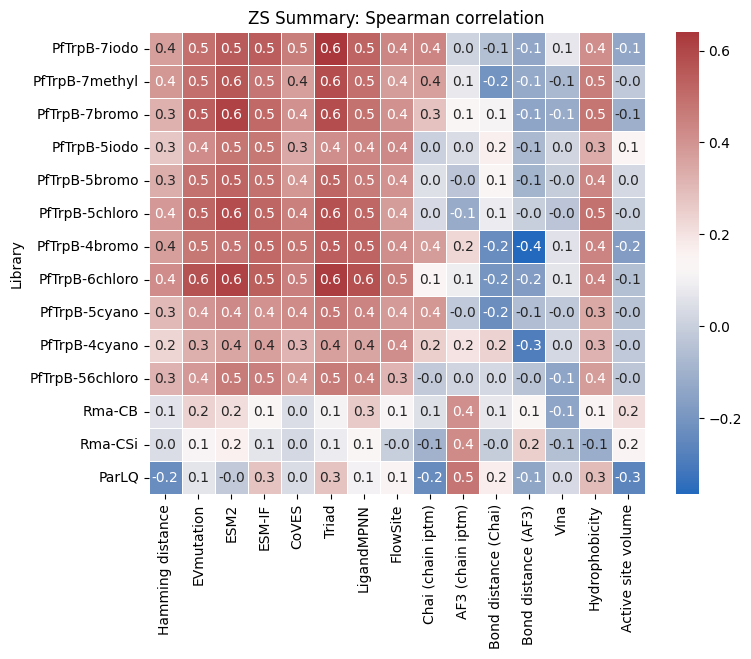

In [24]:
trpb_rho_df = df_rho_fit[df_rho_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation")

Text(0.5, 1.0, 'ZS Summary: Spearman correlation for selectivity')

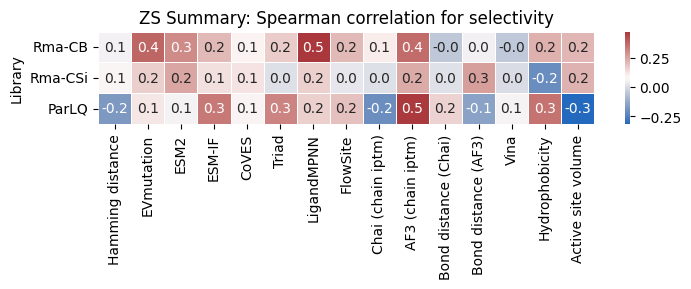

In [28]:

parlq_sele_df = df_rho_sele[df_rho_sele["lib"] == "ParLQ"].copy()
parlq_sele_df = (
    parlq_sele_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.2))
# Create a heatmap
sns.heatmap(
    pd.concat([parlq_sele_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order[-3:]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation for selectivity")

In [ ]:
trpb_rho_df = df_ndcg[df_ndcg["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_ndcg[df_ndcg["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_ndcg[df_ndcg["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_ndcg[df_ndcg["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: NDCG")

In [ ]:
trpb_rho_df = df_top10_fit[df_top10_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top10_fit[df_top10_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top10_fit[df_top10_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top10_fit[df_top10_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 10% recall")

In [ ]:
trpb_rho_df = df_top25_fit[df_top25_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top25_fit[df_top25_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top25_fit[df_top25_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top25_fit[df_top25_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 25% recall")

In [ ]:
trpb_rho_df = df_top50_fit[df_top50_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top50_fit[df_top50_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 50% recall")

In [ ]:
for c in df_rho_fit.columns:
    if " - " in c and "avg" in c:
        print(c)

In [ ]:
hydro_cols = [c for c in df_rho_fit.columns if " - " in c and "_avg" in c]
hydro_df = df_rho_fit[["lib"] + hydro_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(30, 6))
# Create a heatmap
sns.heatmap(hydro_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Hydro")

In [ ]:
hydro_df.mean().sort_values(ascending=False)[:20]

Text(0.5, 1.0, 'Rosetta')

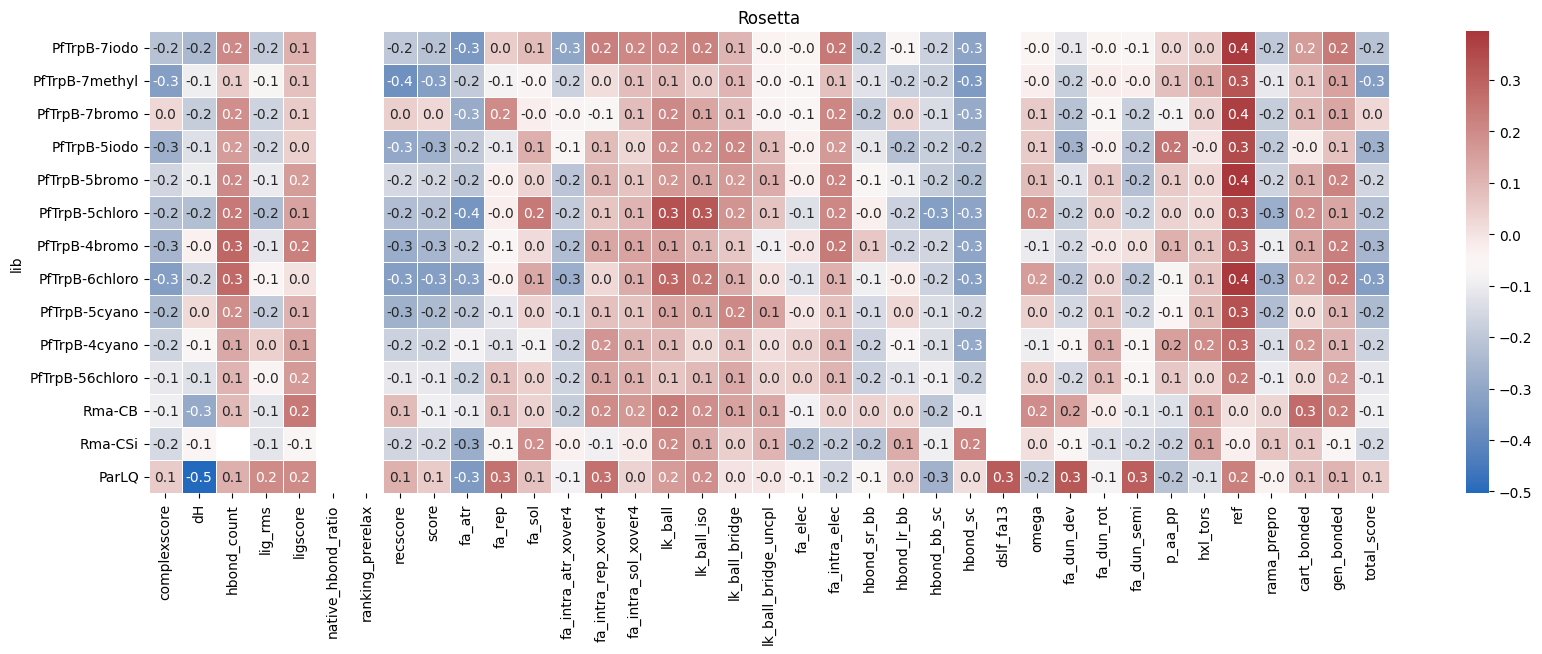

In [15]:
rosetta_cols = [
    "complexscore", "dH", "hbond_count", "lig_rms", "ligscore", "native_hbond_ratio", 
    "ranking_prerelax", "recscore", "score", "fa_atr", "fa_rep", "fa_sol", 
    "fa_intra_atr_xover4", "fa_intra_rep_xover4", "fa_intra_sol_xover4", "lk_ball", 
    "lk_ball_iso", "lk_ball_bridge", "lk_ball_bridge_uncpl", "fa_elec", "fa_intra_elec", 
    "hbond_sr_bb", "hbond_lr_bb", "hbond_bb_sc", "hbond_sc", "dslf_fa13", "omega", 
    "fa_dun_dev", "fa_dun_rot", "fa_dun_semi", "p_aa_pp", "hxl_tors", "ref", 
    "rama_prepro", "cart_bonded", "gen_bonded", "total_score"
]

rosetta_df = df_rho_fit[["lib"] + rosetta_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(20, 6))
# Create a heatmap
sns.heatmap(rosetta_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Rosetta")

In [16]:
rosetta_df.mean().sort_values(ascending=False)[:10]

dslf_fa13         0.310281
ref               0.279242
lk_ball           0.180072
hbond_count       0.172386
lk_ball_iso       0.152592
gen_bonded        0.147406
lk_ball_bridge    0.115993
ligscore          0.114274
cart_bonded       0.110297
fa_intra_elec     0.102379
dtype: float64